In [1]:
from sism.datasets import (generate_concentric_circle_dataset,
                           generate_c4_gmm_dataset,
                           generate_mog_2d,
                           generate_line_distribution
                           )

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from IPython.display import display, clear_output
import math
import numpy as np

/Users/tuanle/Desktop/projects/symmetry-induced-score-matching/sism/datasets.py:120: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/native/TensorShape.cpp:3641.)
  rotated_mean = (R @ mean.T).T


In [2]:
import torch
import torch.nn as nn
figsize = (6, 6)

In [3]:
# Lie algebra basis for dilation and SO(2)
I = torch.eye(2).unsqueeze(0)
A = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32).unsqueeze(0)

In [4]:
torch.matmul(I , I) + torch.matmul(A, A)

tensor([[[0., 0.],
         [0., 0.]]])

In [5]:
torch.matmul(A, A)

tensor([[[-1.,  0.],
         [ 0., -1.]]])

## Fundamental vector fields
The fundamental vector fields are column-stacked into the matrix $\mathbf{\Pi}(\mathbf{x}) = [\Pi_{A_r}(\mathbf{x}), \Pi_{A_\theta}(\mathbf{x})] \in \mathbb{R}^{2\times 2}$ and are defined as 
$$\mathbf{\Pi}(\mathbf{x}) =    \begin{pmatrix}
\Pi_{A_r}(\mathbf{x}), \Pi_{A_\theta}(\mathbf{x})  \\
\end{pmatrix} = \begin{pmatrix}
x_1 & -x_2 \\
x_2&  x_1 \\
\end{pmatrix} $$

Now the differential operators / generalized scores are 
$$
\mathcal{L} = \mathbf{\Pi}(\mathbf{x})^T \nabla = [\frac{\partial}{\partial x_1} x_1 + \frac{\partial}{\partial x_2} x_2, -\frac{\partial}{\partial x_1} x_2 + \frac{\partial}{\partial x_2} x_1 ]
$$

In [6]:
class SO2Prior:
    def __init__(self, std_r=1, std_theta=1):
        self.std_r = std_r
        self.std_theta = std_theta
        self.log_r_d = torch.distributions.Normal(0, 1)
        self.theta_d = torch.distributions.Normal(0, 1)
        
    def sample(self, n):
        r = torch.exp(self.log_r_d.sample((n,)) * self.std_r)
        theta = self.theta_d.sample((n,)) * self.std_theta
        return torch.stack([r, theta], dim=-1)

In [7]:
def coordinate_transform_backward(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    r, theta = input.chunk(2, dim=1)
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.concat([x, y], dim=1)

def coordinate_transform_forward(input):
    if input.dim() == 1:
        input = input.unsqueeze(dim=0)
    x, y = input.chunk(2, dim=1)
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y, x)
    return torch.concat([r, theta], dim=1)

In [8]:
def forward_noising_vp(input: torch.Tensor,
                       s: torch.Tensor,
                       m: torch.Tensor,
                       in_ambient: bool = False,
                       sqrt=True,
                       ):
    
    if s.ndim == 1:
        s = s.unsqueeze(1)
    if m.ndim == 1:
        m = m.unsqueeze(1)
    # ambient space (x,y) into de-coupled space (r, theta)
    r, theta = coordinate_transform_forward(input).chunk(2, dim=1)
    r = r.log()
    # noise variables
    n_r, n_t = torch.randn_like(r), torch.randn_like(theta)
    s2 = s.pow(2)
    l_r = -r * s2 + s * n_r
    l_t = -theta * s2 + s * n_t
    if in_ambient:
        b = input.shape[0]
        cos, sin = l_t.cos(), l_t.sin()
        A0 = l_r.exp()
        A1 = torch.concat([cos, -sin, 
                           sin, cos],
                          dim=-1).view(b, 2, 2)
        xt = A0 * torch.einsum("bij,bj->bi", [A1, input])
    else:
        if sqrt:
            m = m.sqrt()
        rt = m * r + s * n_r
        tt = m * theta + s * n_t
        input = torch.concat([rt.exp(), tt], dim=1)
        xt = coordinate_transform_backward(input)
    l = torch.concat([n_r, n_t], dim=1)
    return xt, l

In [9]:
T = 100
def get_diffusion_coefficients(T, kind="linear-time", alpha_clip_min=0.001):
    if kind == "linear-time":
        t = np.linspace(1e-3, 1.0, T + 2)
        alphas_cumprod = 1.0 - t
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        betas = 1 - alphas
        betas = np.clip(betas, 0.0, 1.0 - alpha_clip_min)
        betas = torch.from_numpy(betas).float().squeeze()
    elif kind == "cosine":
        s = 0.008
        steps = T + 2
        x = torch.linspace(0, T, steps)
        alphas_cumprod = (
            torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5)
            ** 2
        )
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        alphas = alphas.clip(min=alpha_clip_min)
        betas = 1 - alphas
        betas = torch.clip(betas, 0.0, 1.0 - alpha_clip_min).float()
    elif kind == "ddpm":
        betas = torch.linspace(0.1 / T, 20 / T, T + 1)
    return betas

In [10]:
T = 100
betas = get_diffusion_coefficients(T, kind="cosine")

In [11]:
alpha = 1.0 - betas
mean_coeff = alpha.cumprod(dim=0)
std_coeff = (1.0 - mean_coeff).sqrt()

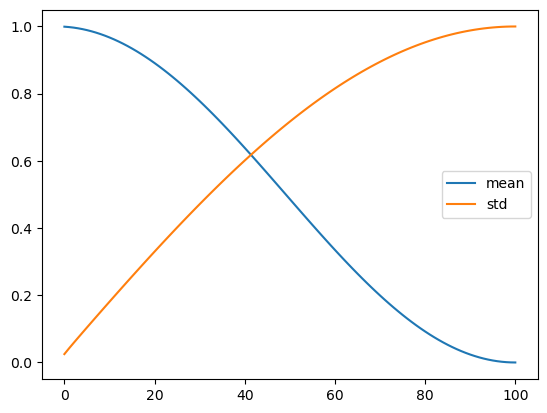

In [12]:
plt.plot(range(T+1), mean_coeff, label="mean")
plt.plot(range(T+1), std_coeff, label="std")
plt.legend()
plt.show()

In [13]:
def get_dataset(mode: str = "mog"):

    if mode == "mog":
        dataset, _ = generate_mog_2d(nsamples=10_000)
    elif mode == "c4gaussian":
        dataset = generate_c4_gmm_dataset(nsamples=10_000)
    elif mode == "concentric_circles":
        dataset = generate_concentric_circle_dataset(nsamples=10_000)
    elif mode == "line":
        dataset = generate_line_distribution(nsamples=10_000)
    else:
        raise ValueError(f"Unknown mode {mode}")

    if isinstance(dataset, torch.Tensor):
        x = dataset.clone()
    else:
        x = torch.from_numpy(dataset).float()

    ids = np.arange(len(dataset))
    torch_dataset = x.clone()
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[:, 0], dataset[:, 1], s=2,)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()
    return torch_dataset, x, ids

# Experiment on Mixture of Gaussians

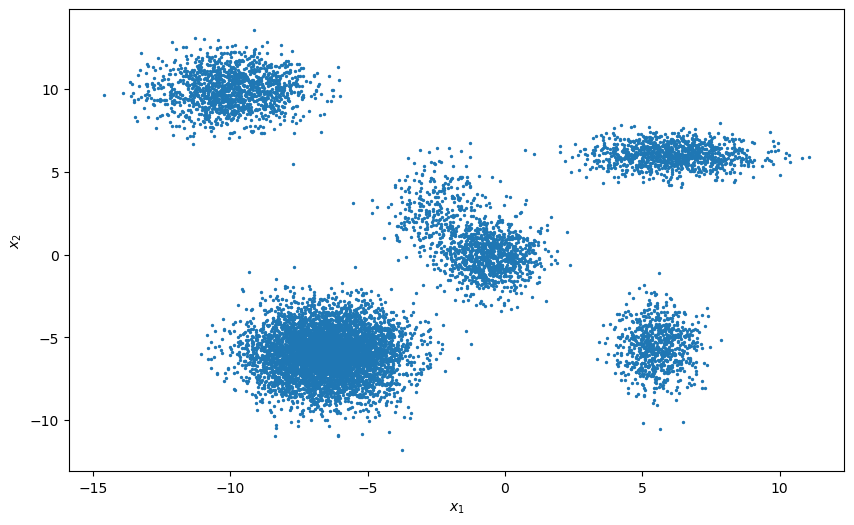

In [14]:
torch_dataset, x, ids = get_dataset("mog")
bs = 128

### Generalized Score Matching with Lie Group Actions

In [15]:
def train_model(torch_dataset):
    in_dim = 2
    hidden_dim = 32
    device = "cpu"
    epochs = 1000
    score_net = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                            nn.SiLU(), 
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.SiLU(), 
                            nn.Linear(hidden_dim, in_dim),
                            ).to(device)

    normalize_tgt_by_std = True

    optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)
    epoch_losses = []
    with tqdm(range(epochs), unit="epoch") as tepoch:
        for epoch in tepoch:
            epoch_loss = 0.0
            np.random.shuffle(ids)
            split = np.array_split(ids, math.ceil(len(ids) / bs))
            cnt = 0
            for i, idx in enumerate(split):
                t = torch.randint(low=1, high=T+1, size=(len(idx),))
                temb= (t / T).unsqueeze(-1)
                
                w = 1 + (1 / (temb + 1))
                w = torch.ones_like(w)
                
                signal = mean_coeff[t].unsqueeze(1)
                std = std_coeff[t].unsqueeze(1)
                
                xin = torch_dataset[idx]
                xt, target = forward_noising_vp(input=xin, m=signal, s=std, 
                                                in_ambient=False,
                                                sqrt=True
                                                )
                
                optimizer.zero_grad()
                score = score_net(torch.concat([xt, temb], dim=1))
                target = - (target / std) if normalize_tgt_by_std else -target
                assert score.ndim == 2 and target.ndim == 2
                loss = (score - target).pow(2).sum(-1)
                loss = (w.squeeze(-1) * loss).mean()
                loss.backward()
                nn.utils.clip_grad_norm_(score_net.parameters(), 10.0)
                optimizer.step()
                
                epoch_loss += loss.item()
                cnt += 1
            epoch_loss /= cnt
            epoch_losses.append(epoch_loss)
            tepoch.set_postfix(loss=epoch_loss)
            
    plt.figure(figsize=figsize)
    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve GSM Score Network ")
    plt.show()
    return score_net

  0%|          | 0/1000 [00:00<?, ?epoch/s]

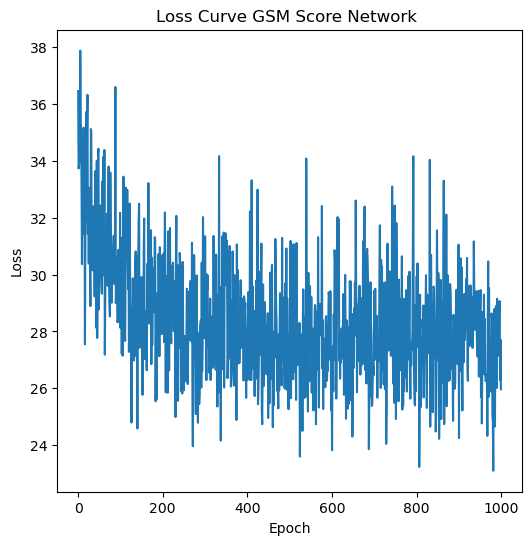

In [16]:
score_net_mog = train_model(torch_dataset)

#### Sampling with generalized scores
Since we implement the dynamics with dilation and 2D rotations in $\mathbb{R}^2$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic` or `theta_dynamic` to `False` to see how the trajectory can be decomposed.

In [17]:

def run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net):
    assert (sum((r_dynamic, theta_dynamic)) > 0)

    r_theta = prior.sample(n=num_samples)
    xsampled = coordinate_transform_backward(r_theta)

    x_traj = []
    xnumpy = x.detach().cpu()

    fig, ax = plt.subplots(figsize=figsize)
    scatter_plot = ax.scatter(xsampled.detach().cpu()[:, 0],
                            xsampled.detach().cpu()[:, 1],
                            s=5, alpha=0.2, color='red', label="generated")
    true_plot = ax.scatter(xnumpy[:, 0],
                        xnumpy[:, 1],
                        s=5, alpha=0.2, color='blue', label="true")

    time_text = ax.text(5.0, 3.0, '$t=0$', fontsize=14)
    ax.axis('equal')

    ax.set_xlim(-15.0, 15.0)
    ax.set_ylim(-15.0, 15.0)
    ax.axis("off") # remove the axis will speed up the training
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)

    with torch.no_grad():
        for i, t in tqdm(enumerate(reversed(chain)), total=T):        
            t_ = torch.tensor([t] * num_samples)
            
            beta = betas[t_].unsqueeze(-1)
            temb = (t_ / T).unsqueeze(-1)
            score = score_net(torch.concat([xsampled, temb], dim=-1))
            
            r, theta = coordinate_transform_forward(xsampled).chunk(2, dim=1)
            
            # drift and score
            dr = (0.5 * r.log() + score[:, 0].unsqueeze(-1)) * torch.einsum('bij, bj -> bi', (I, xsampled))
            dtheta = (0.5 * theta + score[:, 1].unsqueeze(-1))* torch.einsum('bij, bj -> bi', (A, xsampled))
            
            noise = torch.randn_like(score)
            nr = noise[:, 0].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (I, xsampled))
            ntheta = noise[:, 1].unsqueeze(-1) * torch.einsum('bij, bj -> bi', (A, xsampled))
            
            if r_dynamic:
                x_update = xsampled + beta * dr 
            else:
                x_update = xsampled
                
            if theta_dynamic:
                x_update = x_update + beta * dtheta 
            
            if stochastic:
                # noise term + casimir invariant terms + divergence term
                if r_dynamic:
                    x_update = x_update + beta.sqrt() * nr + 0.5 * beta * xsampled + 2. * beta * xsampled
                if theta_dynamic:
                    x_update = x_update + beta.sqrt() * ntheta - 0.5 * beta * xsampled
            
            xsampled = x_update
            
            x_traj.append(xsampled)
            time_text.set_text(f'$t={i+1} / {T}$')
            scatter_plot.set_offsets(xsampled.cpu().detach().numpy())
            x_traj.append(xsampled)
            clear_output(wait=True)
            display(fig)

In [18]:
prior = SO2Prior(std_r=1., std_theta=1.)
num_samples = 1000
chain = np.arange(T)
stochastic = True


In [ ]:
torch_dataset, x, ids = get_dataset("mog")
bs = 128

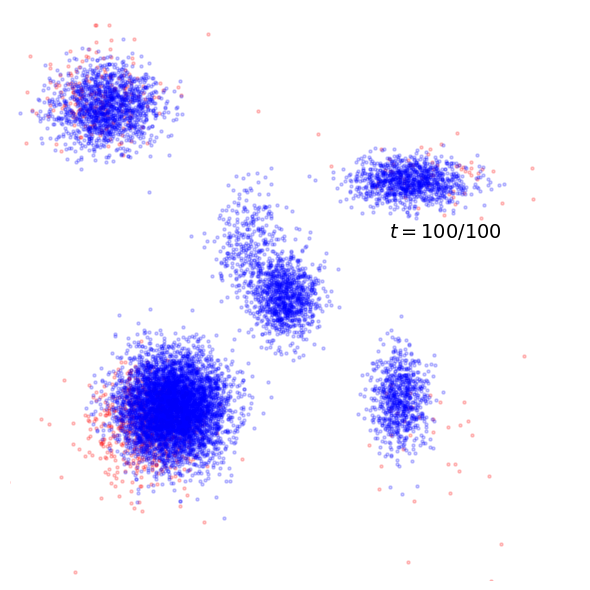

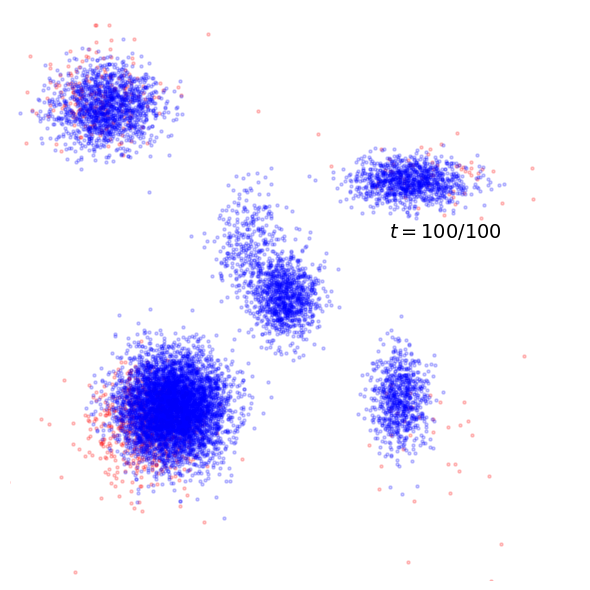

In [20]:
r_dynamic = True 
theta_dynamic = True
run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_mog)

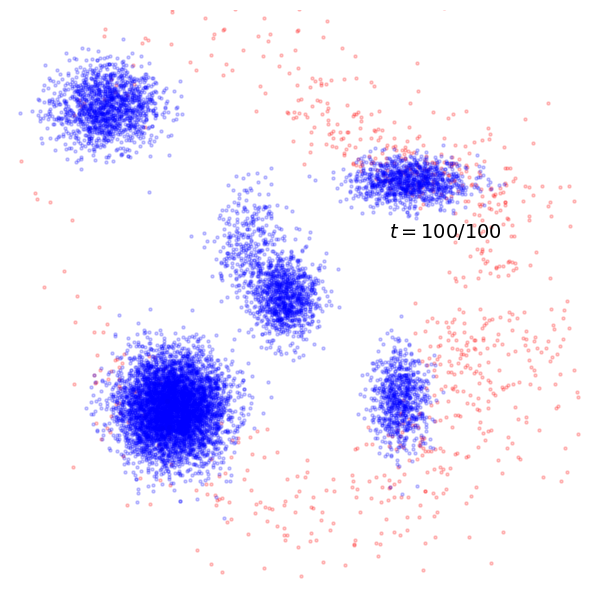

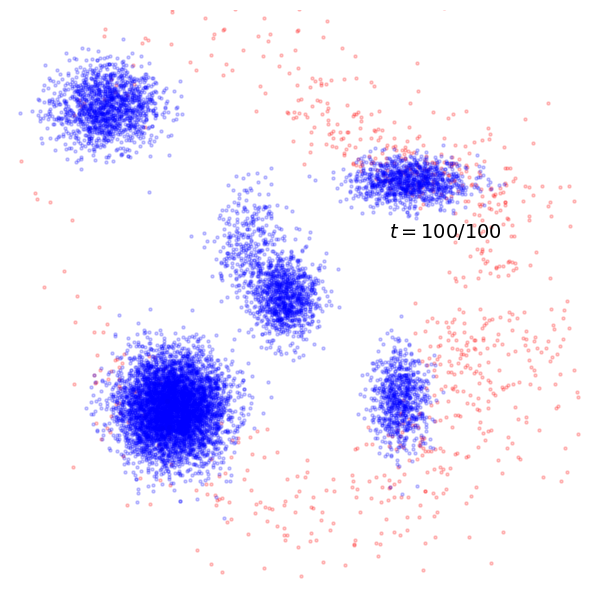

In [23]:
r_dynamic = True 
theta_dynamic = False
run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_mog)

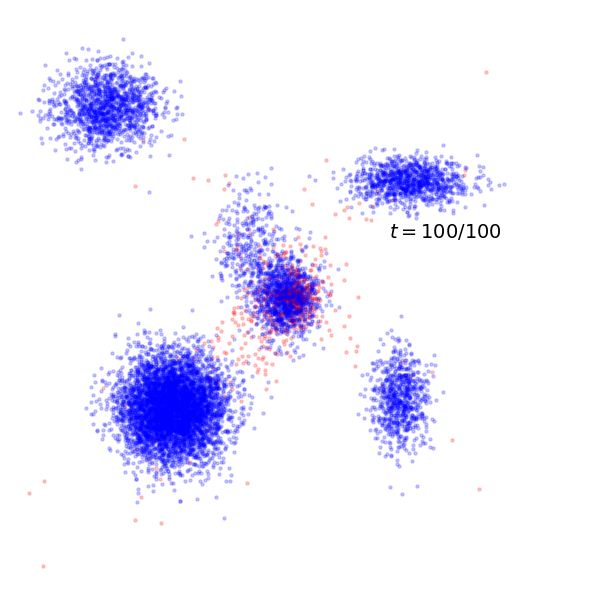

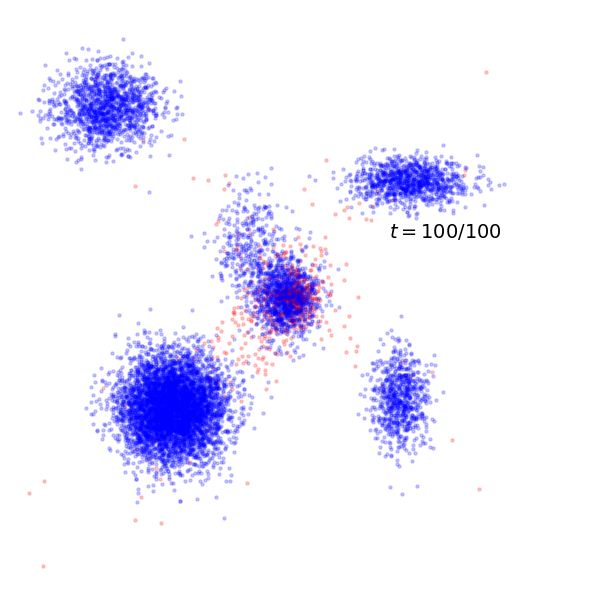

In [22]:
r_dynamic = False 
theta_dynamic = True
run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_mog)

# Experiment on C4 Gaussians

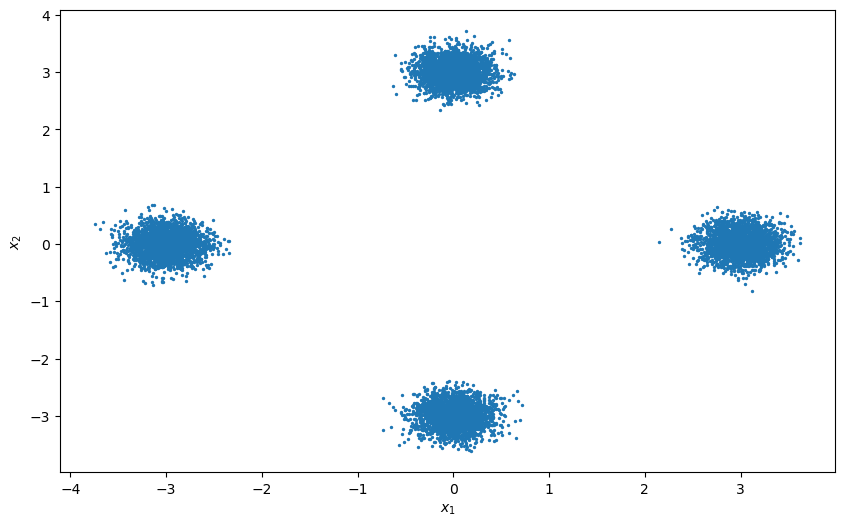

In [24]:
torch_dataset, x, ids = get_dataset("c4gaussian")
bs = 128

### Generalized Score Matching with Lie Group Actions

  0%|          | 0/1000 [00:00<?, ?epoch/s]

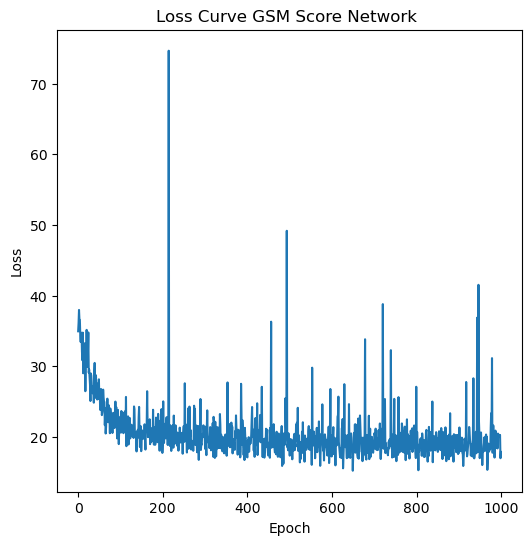

In [25]:
score_net_c4 = train_model(torch_dataset)


#### Sampling with generalized scores
Since we implement the dynamics with dilation and 2D rotations in $\mathbb{R}^2$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic` or `theta_dynamic` to `False` to see how the trajectory can be decomposed.

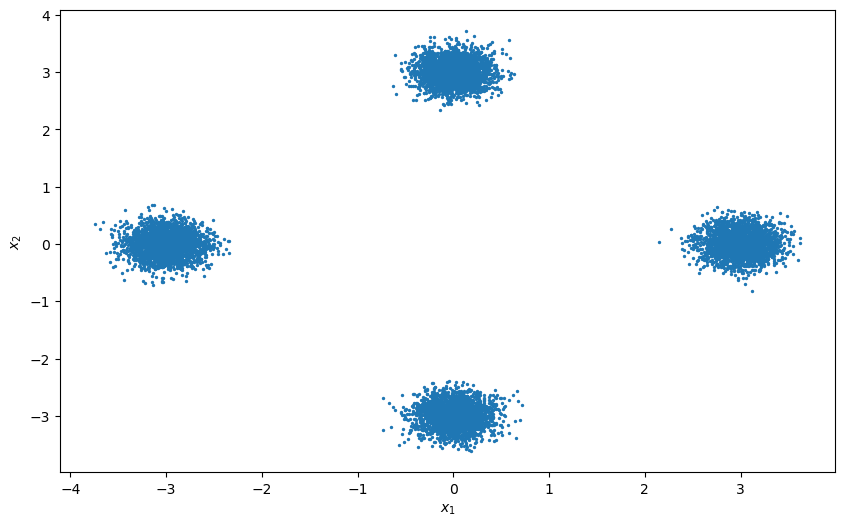

In [53]:
torch_dataset, x, ids = get_dataset("c4gaussian")
bs = 128

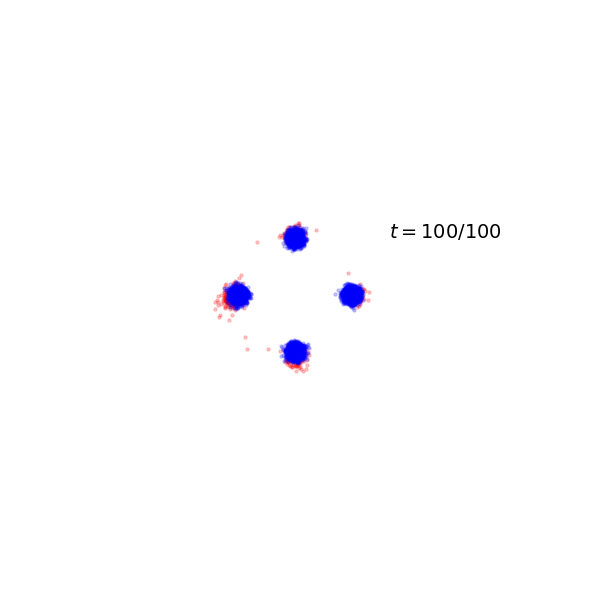

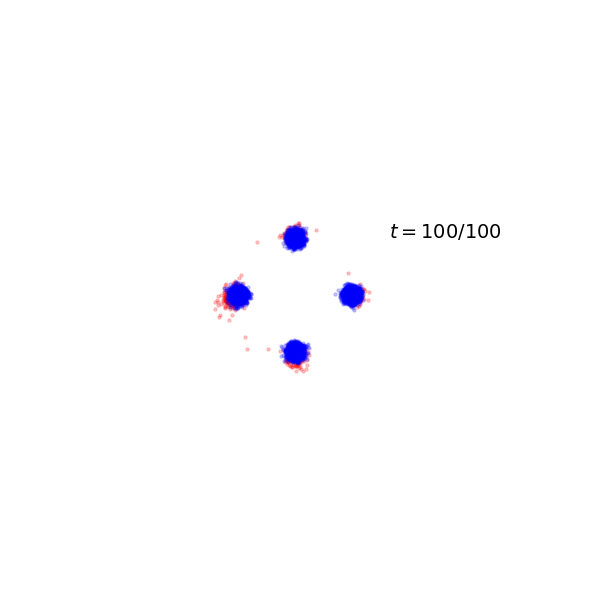

In [57]:
prior = SO2Prior(std_r=1., std_theta=1.)
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_c4)

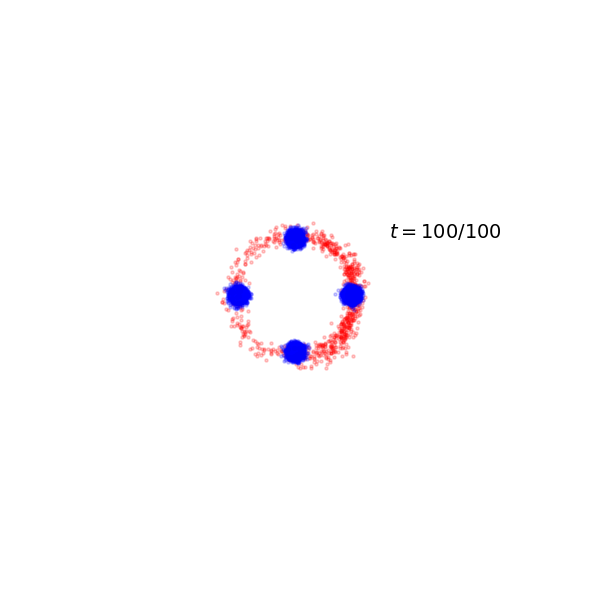

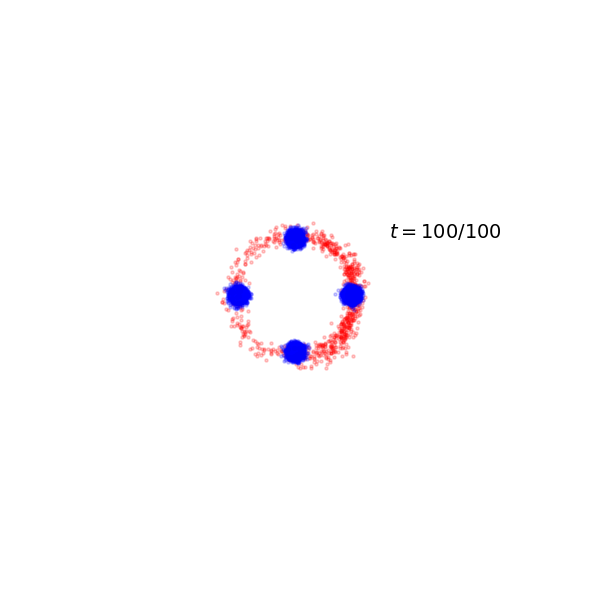

In [60]:
r_dynamic = True 
theta_dynamic = False

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_c4)

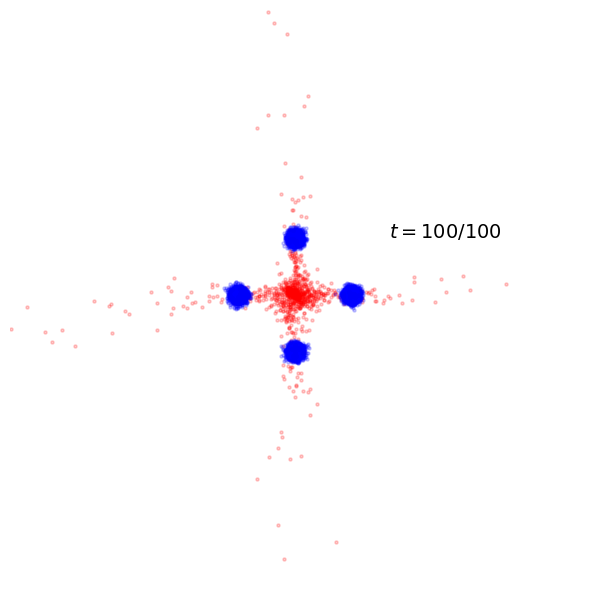

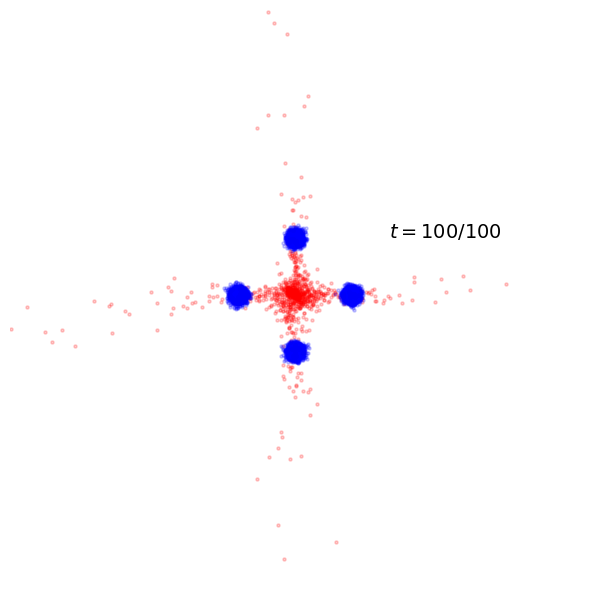

In [61]:
r_dynamic = False 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_c4)

# Experiment on Concentric Circles

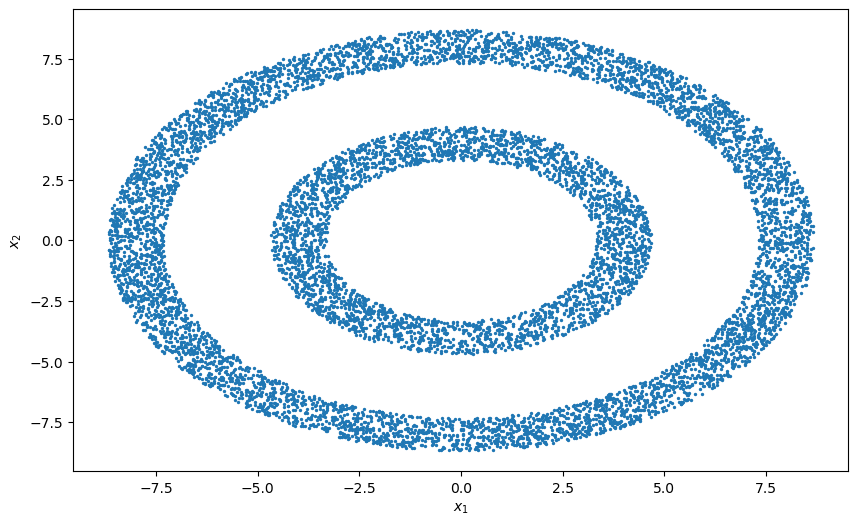

In [29]:
torch_dataset, x, ids = get_dataset("concentric_circles")
bs = 128

### Generalized Score Matching with Lie Group Actions

  0%|          | 0/1000 [00:00<?, ?epoch/s]

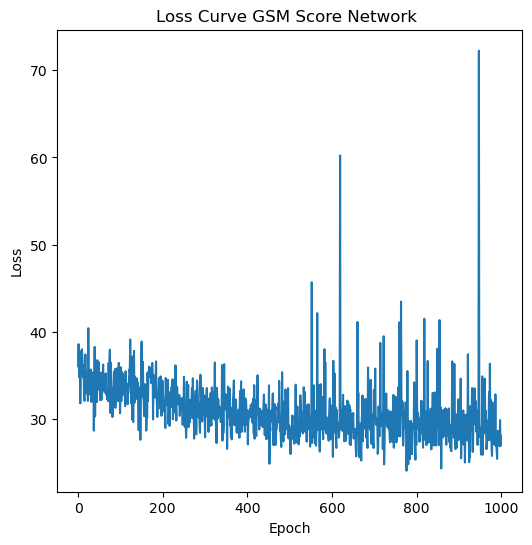

In [30]:
score_net_concentric = train_model(torch_dataset)

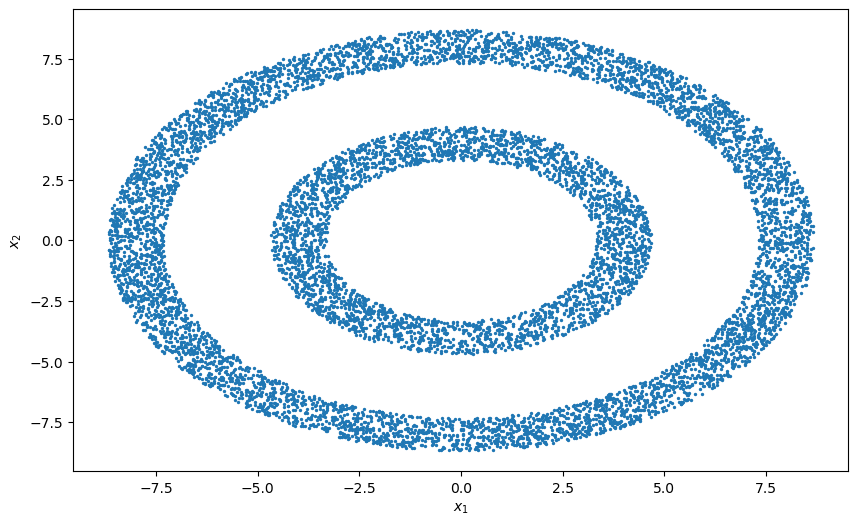

In [46]:
torch_dataset, x, ids = get_dataset("concentric_circles")
bs = 128

#### Sampling with generalized scores
Since we implement the dynamics with dilation and 2D rotations in $\mathbb{R}^2$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic` or `theta_dynamic` to `False` to see how the trajectory can be decomposed.

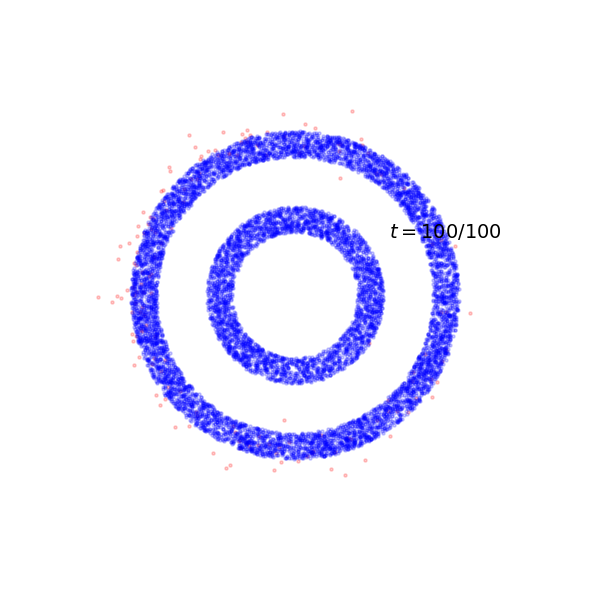

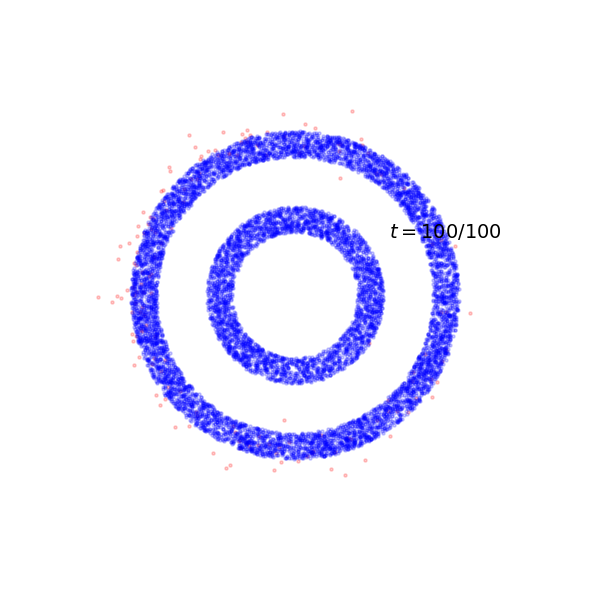

In [50]:
prior = SO2Prior(std_r=1., std_theta=1.)
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_concentric)

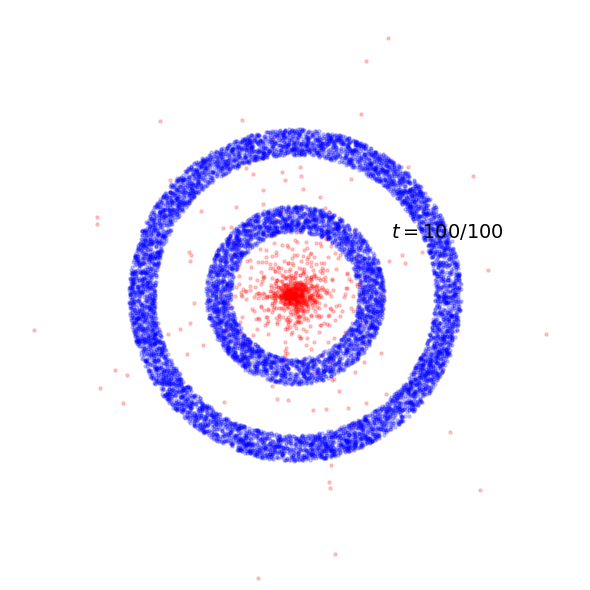

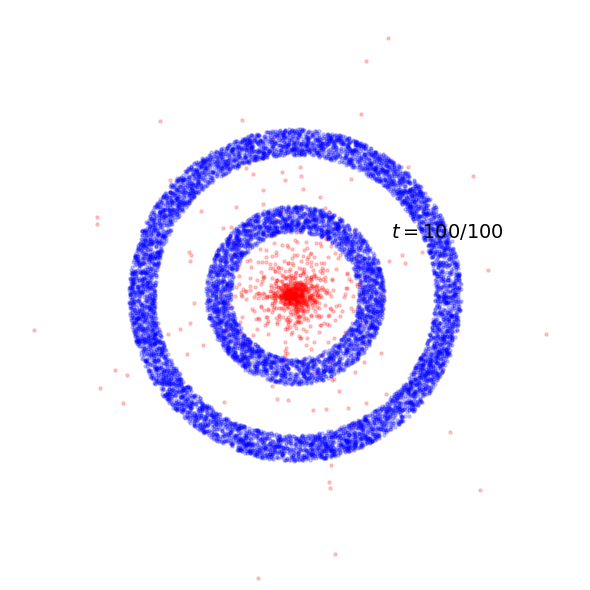

In [51]:
r_dynamic = False 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_concentric)

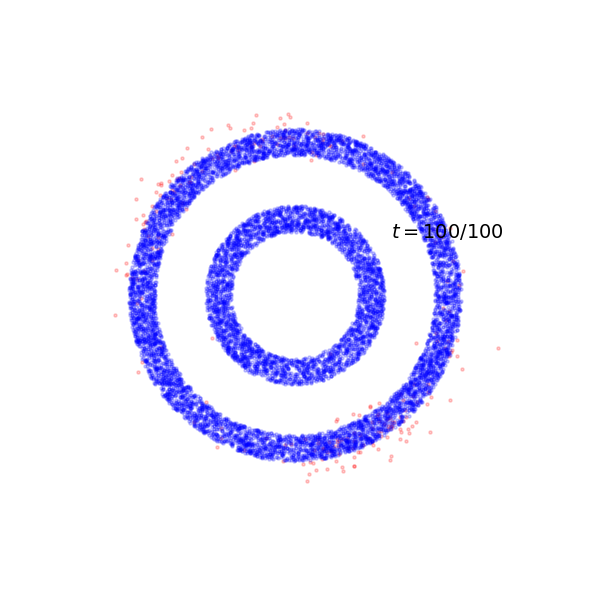

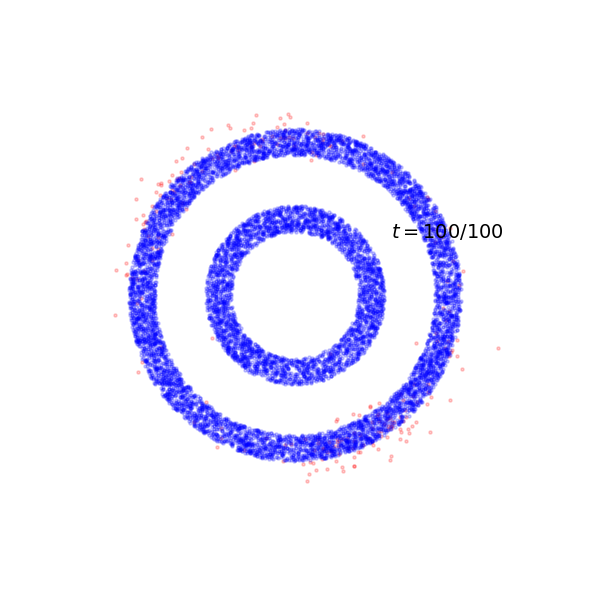

In [52]:
r_dynamic = True 
theta_dynamic = False

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_concentric)

# Experiment on Line Distribution

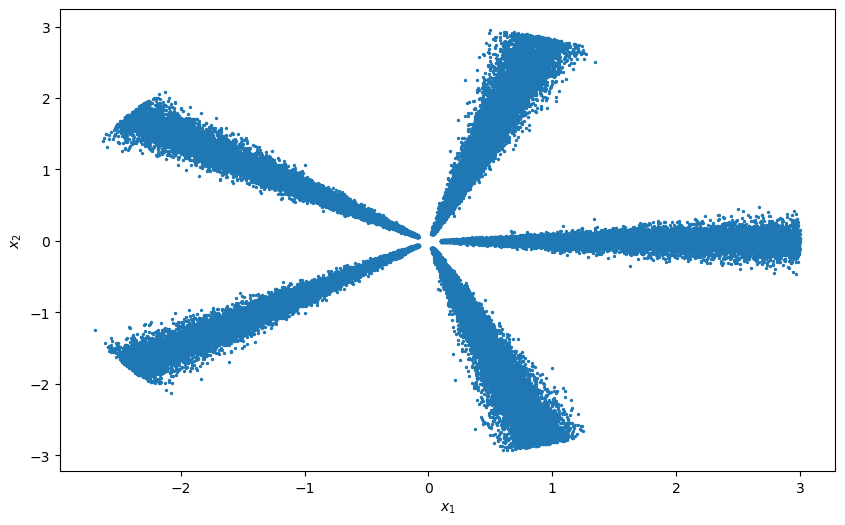

In [36]:
torch_dataset, x, ids = get_dataset("line")
bs = 128

### Generalized Score Matching with Lie Group Actions

  0%|          | 0/1000 [00:00<?, ?epoch/s]

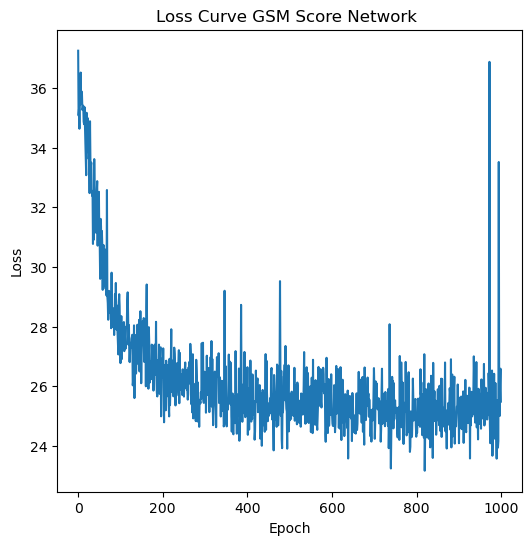

In [37]:
score_net_line = train_model(torch_dataset)


#### Sampling with generalized scores
Since we implement the dynamics with dilation and 2D rotations in $\mathbb{R}^2$, the scores contribute to a radial and angular part.
For sampling, you can set either `r_dynamic` or `theta_dynamic` to `False` to see how the trajectory can be decomposed.

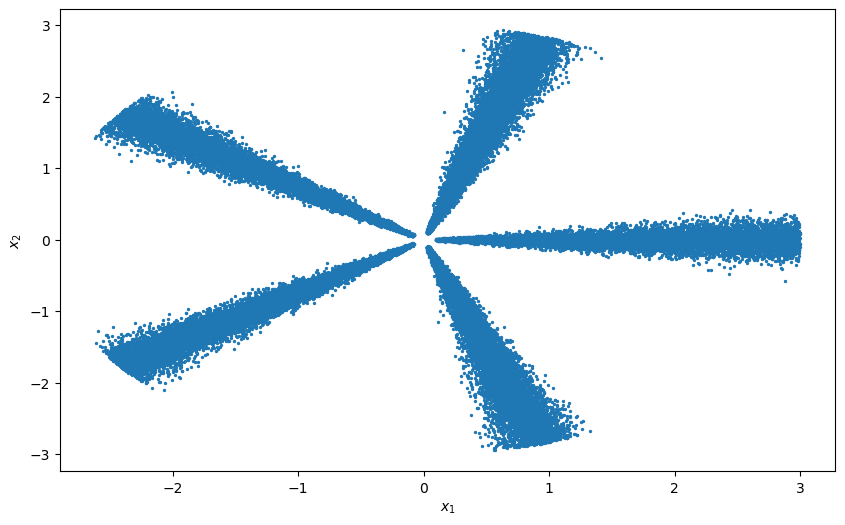

In [62]:
torch_dataset, x, ids = get_dataset("line")
bs = 128

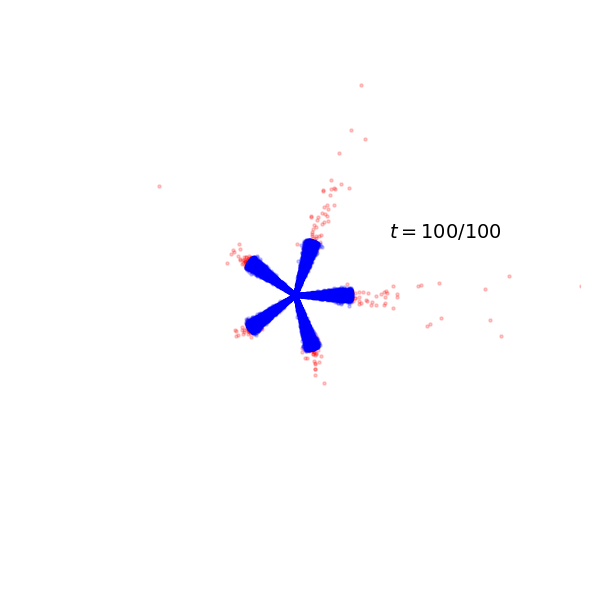

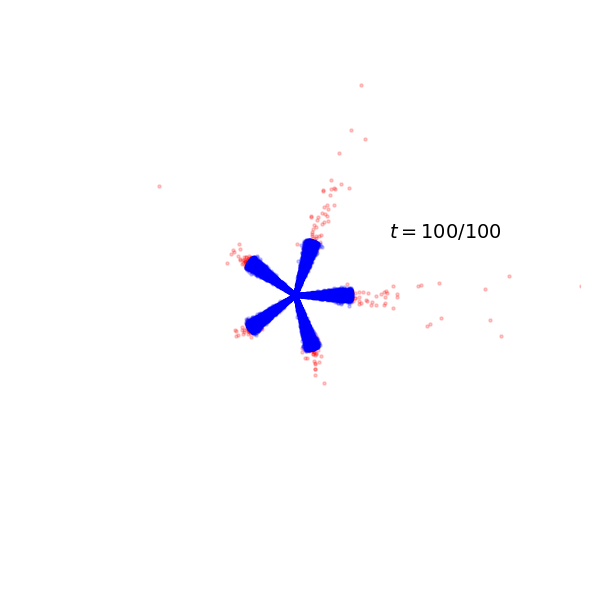

In [63]:
prior = SO2Prior(std_r=1., std_theta=1.)
num_samples = 1000
chain = np.arange(T)
stochastic = True

r_dynamic = True 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_line)

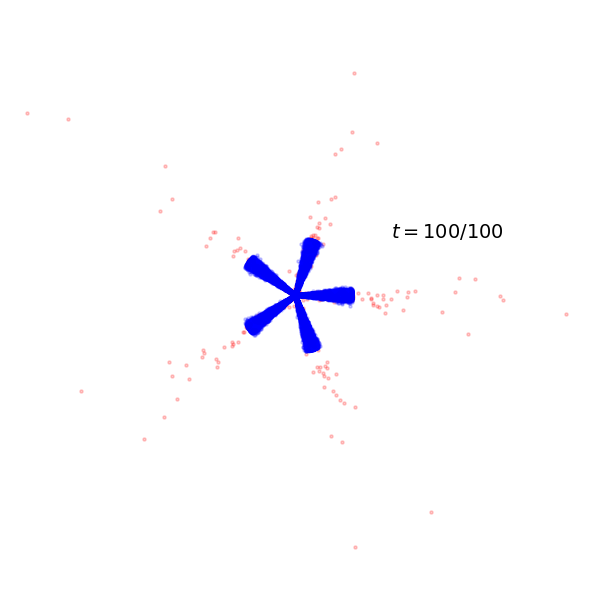

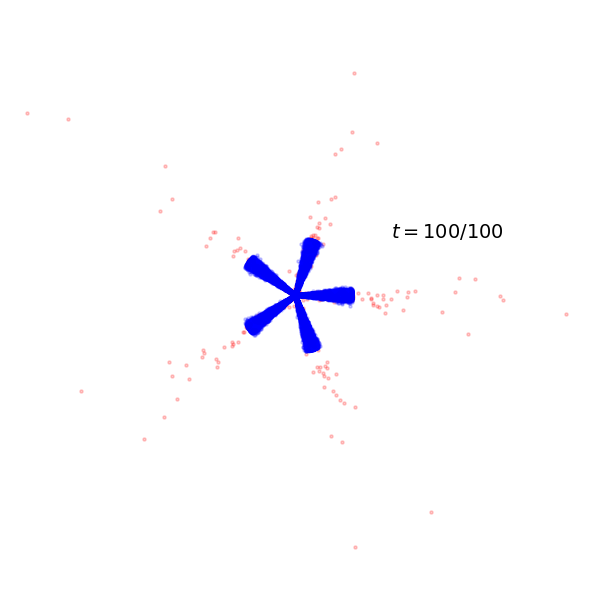

In [64]:
r_dynamic = False 
theta_dynamic = True

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_line)

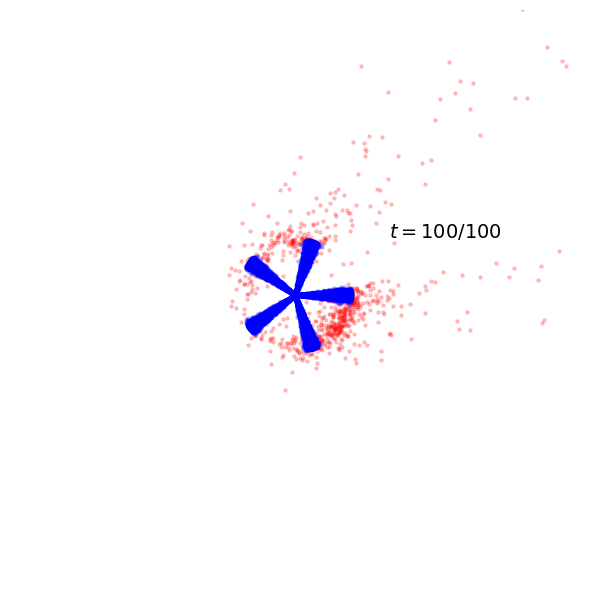

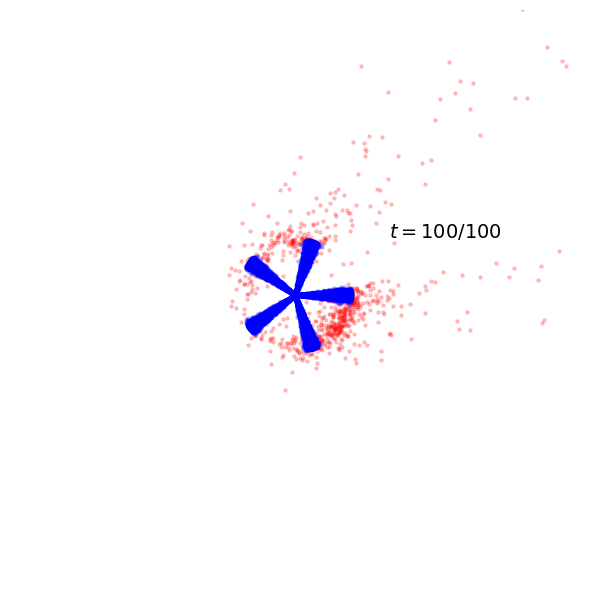

In [65]:
r_dynamic = True 
theta_dynamic = False

run_generation(prior, chain, stochastic, r_dynamic, theta_dynamic, num_samples, score_net_line)